# L'orbite de S2 et sa précession de Schwarzschild

[Gravity Collaboration et al. (2020)] (https://arxiv.org/pdf/2004.07187.pdf) a annoncé la détection de la précession de Schwarzschild de l'étoile S2 qui est en orbite autour du trou noir supermassif au centre de la Voie lactée.

## Conditions initiales du modèle

Les conditions initiales de l'étude sont définies à partir de coordonnées basées sur des éléments orbitaux, nous devons donc les convertir en coordonnées cartésiennes. Pour ce faire, nous utilisons la bibilothèque ``rebound``. Nous mettons en place une simulation avec les éléments orbitaux donnés par l'étude :

In [1]:
import numpy
import astropy.units as u
import rebound
from galpy.orbit import Orbit
from galpy.util import bovy_coords
from galpy.potential import KeplerPotential
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,
                     xtick_labelsize=15.,ytick_labelsize=15.)
_SAVE_GIFS= False

In [2]:
R0= 8246.7*u.pc
vo= 220.*u.km/u.s
MSgrA= 4.261*10**6*u.Msun
sim= rebound.Simulation()
sim.units= ('AU', 'yr', 'Msun')
# GC
sim.add(m=MSgrA.to_value(u.Msun))
# S2
sim.add(m=0.,
        a=(125.058*u.mas*R0).to_value(u.AU,equivalencies=u.dimensionless_angles()),
        e=0.884649,
        inc=(134.567*u.deg).to_value(u.rad),
        omega=(66.263*u.deg).to_value(u.rad),
        Omega=(228.171*u.deg).to_value(u.rad),
        T=(8.37900*u.yr).to_value(u.yr)-0.35653101) # time since 2010's apocenter (calculated: 2010+0.35653101)

Ensuite, nous convertissons en coordonnées cartésiennes cylindriques et initialisons une orbite ``galpy``. Le référentiel cartésien utilisé dans l'étude est celui dont la composante $X-Y$ est le plan du ciel et $Z$ la direction de la ligne de visée où la composante $Y$ correspond à RA et la composante $X$ à Dec. Ainsi, nous initialisons l'orbite dans ``galpy`` en utilisant ``radec=True`` et calculons les coordonnées initiales RA, Dec, dist, pmra, pmdec et vlos en utilisant la position de Sgr A* comme référence :

In [3]:
ogc= Orbit([0.,0.,0.,0.,0.,0.],ro=R0,vo=vo)

In [4]:
pt= sim.particles[1]
o= Orbit([(ogc.ra()*u.deg+(pt.y*u.AU/R0).to(u.deg,equivalencies=u.dimensionless_angles())).to_value(u.deg),
          (ogc.dec()*u.deg+(pt.x*u.AU/R0).to(u.deg,equivalencies=u.dimensionless_angles())).to_value(u.deg),
          (ogc.dist()*u.kpc+pt.z*u.AU).to_value(u.kpc),
          (ogc.pmra()*(u.mas/u.yr)+(pt.vy*u.AU/u.yr/R0).to(u.mas/u.yr,equivalencies=u.dimensionless_angles())).to_value(u.mas/u.yr),
          (ogc.pmdec()*(u.mas/u.yr)+(pt.vx*u.AU/u.yr/R0).to(u.mas/u.yr,equivalencies=u.dimensionless_angles())).to_value(u.mas/u.yr),
          (ogc.vlos()*(u.km/u.s)+pt.vz*u.AU/u.yr).to_value(u.km/u.s)],radec=True,ro=R0,vo=vo)

## Intégrale de l'orbite

Intégrons l'orbite avec la bibliothèque ``galpy``:

In [5]:
periods= 2.
times= numpy.linspace(0.,periods*16.0455,100001)*u.yr # 2 periods
kp= KeplerPotential(amp=MSgrA,ro=R0)
o.integrate(times,kp)

L'orbite obtenue pour Sgr A* en Ra et en Dec ne ressemble pas exactement à celle obtenue dans l'étude. Sûrement un problème de conversion d'unités.

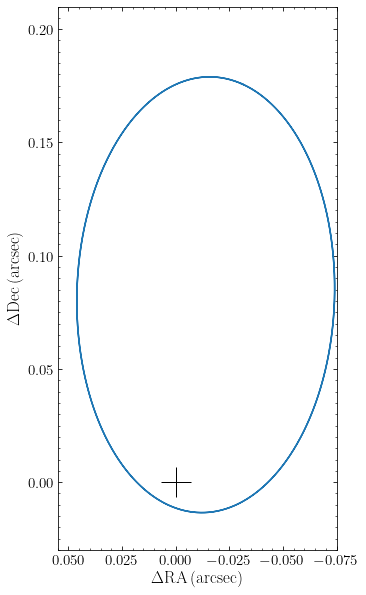

In [6]:
mpl.rcParams['figure.figsize'] = (5., 10.)
o.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
      xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
      ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')

plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.055,-0.075)
plt.ylim(-0.03,0.21);

## Modeling Schwarzschild precession

Utilisons cette équation comme modèle pour la précession de Schwarzschild :

\begin{equation}
    \vec{a}_{\mathrm{SP}} = f_\mathrm{SP}\,\frac{GM}{c^2r^2}\left[\left(2(\gamma+\beta)\,\frac{GM}{r}-\gamma\,v^2\right)\frac{\vec{r}}{r}+2(1+\gamma)\,v_r\,\vec{v}\right]\,.
\end{equation}


In [7]:
from galpy.potential.DissipativeForce import DissipativeForce
from astropy.constants import c
c= c.to_value(u.km/u.s)
class SchwarzschildPrecessionForce(DissipativeForce):
    def __init__(self,amp=1.,fsp=1.,gamma=1.,beta=1.,ro=None,vo=None):
        DissipativeForce.__init__(self,amp=amp,ro=ro,vo=vo,
                                  amp_units='mass')
        self._fsp= fsp
        self._gamma= gamma
        self._beta= beta
    # Following functions implement the vec{r}/r and \vec{v} parts, respectively
    def _force_firstterm(self,r,v):
        return 1./(c/self._vo)**2./r**3.*(2.*(self._gamma+self._beta)*self._amp/r-self._gamma*v**2.)
    def _force_secondterm(self,r,vr):
        return 2.*(1.+self._gamma)/(c/self._vo)**2./r**2.*vr
    # Now compute the three projections of the forve
    def _Rforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        vmag= numpy.sqrt(v[0]**2.+v[1]**2.+v[2]**2.)
        return self._fsp*(self._force_firstterm(r,vmag)*R+self._force_secondterm(r,vr)*v[0])
    def _zforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        vmag= numpy.sqrt(v[0]**2.+v[1]**2.+v[2]**2.)
        return self._fsp*(self._force_firstterm(r,vmag)*z+self._force_secondterm(r,vr)*v[2])
    def _phiforce(self,R,z,phi=0.,t=0.,v=None):
        r= numpy.sqrt(R**2.+z**2.)
        vr= R/r*v[0]+z/r*v[2]
        return self._fsp*(self._force_secondterm(r,vr)*v[1]*R)

In [8]:
sp= SchwarzschildPrecessionForce(amp=MSgrA,ro=R0,fsp=1.)

In [9]:
times= numpy.linspace(0.,5.*16.0455,1001)*u.yr
o.integrate(times,kp)
osp= o()
osp.integrate(times,kp+sp)

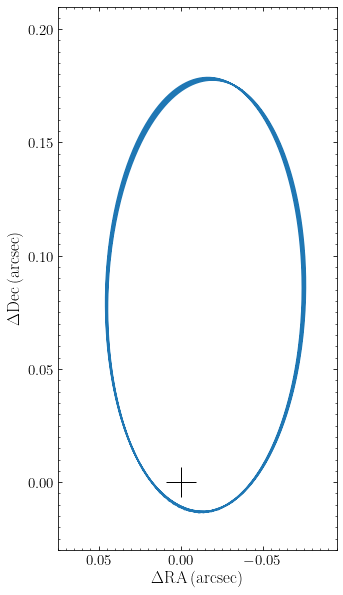

In [10]:
mpl.rcParams['figure.figsize'] = (5., 10.)
osp.plot(d1='(ra-{})*{}'.format(ogc.ra(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
       d2='(dec-{})*{}'.format(ogc.dec(),
                              (u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())),
        xlabel=r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$',
      ylabel=r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
plt.plot([0.],[0.],'k+',ms=30.)
plt.xlim(0.075,-0.095)
plt.ylim(-0.03,0.21);

## Animation de l'orbite

Ensuite, nous faisons une animation de la précession de l'orbite de S2. Pour cela, nous intégrons pendant un temps puis nous traçons les images successives d'une seule orbite :

In [11]:
nperiods= 200.
times= numpy.linspace(0.,nperiods*16.0455,1000001)*u.yr # 4 periods
o.integrate(times[times < 16.0455*u.yr],kp)
osp= o()
osp.integrate(times,kp+sp)

In [12]:
def delta_ra(ra):
    return (ra-ogc.ra())*(u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())
def delta_dec(dec):
    return (dec-ogc.dec())*(u.deg/u.arcsec).to(u.dimensionless_unscaled,equivalencies=u.dimensionless_angles())

mpl.rcParams['figure.figsize'] = (6., 7.)

fig, ax= plt.subplots()
line2= plt.plot([0.],[0.],'k+',ms=10.)

plt.xlabel(r'$\Delta \mathrm{RA}\,(\mathrm{arcsec})$')
plt.ylabel(r'$\Delta \mathrm{Dec}\,(\mathrm{arcsec})$')
plt.xlim(0.075,-0.25)
plt.ylim(-0.19,0.26)

nstride= round(len(times)/nperiods)+1
line,= ax.plot(delta_ra(osp.ra(times[:nstride])),delta_dec(osp.dec(times[:nstride])),'-')
txt= ax.annotate(r'$\mathrm{year}=%.0f$' % (round(2010.35653101,-1)),
                 (0.05,0.05),xycoords='axes fraction',
                 horizontalalignment='left',verticalalignment='bottom',size=18.)
plt.legend(frameon=False,fontsize=18.,loc='upper right')

def animate(ii):
    minii= int(round((ii+0.5)*nstride))
    maxii= int(round((ii+1.5)*nstride))
    line.set_xdata(delta_ra(osp.ra(times[minii:maxii])))
    line.set_ydata(delta_dec(osp.dec(times[minii:maxii])))
    txt.set_text(r'$\mathrm{year}=%.0f$' % (round(2010.35653101+times[ii*nstride].to_value(u.yr),-1)))
    return (line,)
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=len(times)//nstride,interval=1,blit=True,repeat=True)
plt.tight_layout()
anim.save('gravity-sp.gif',writer='ffmpeg',dpi=200)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter ffmpeg unavailable; using Pillow instead.
